# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The data represents 17 marketing campaigns occured between May 2008 and Nov 2010, corresponding to a total of 79354 contacts.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.dummy import DummyClassifier
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, balanced_accuracy_score, f1_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from time import time
from sklearn.inspection import permutation_importance

In [2]:
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [4]:
bank.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

Lets plot some visualizations to understand the data better.

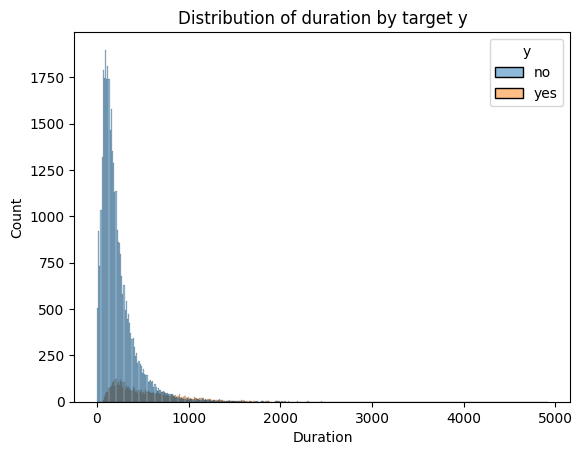

In [5]:
sns.histplot(data =bank, x = 'duration', hue='y')
plt.title('Distribution of duration by target y')
plt.xlabel('Duration')
plt.savefig('images/duration_distribution.png')


We first would like to see how duration data is spread in the dataset as it impacts the target variable heavily. Also, we group by the target 'y' to see how its distributed between yes and no.

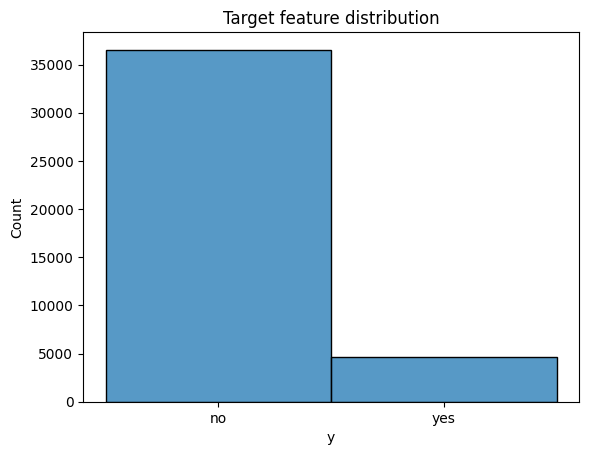

In [6]:
sns.histplot(data = bank, x ='y')
plt.title('Target feature distribution')
plt.savefig('images/target_feature_distribution.png')

We should see how the target feature is distributed in the dataset and in the above histogram, we could see the split of the target feature 'y'. The data seems to be imblanaced and thus we need to consider this when modeling.

In [7]:
def plot_facet_kde(col, col_wrap=3):
  """
     Method for FacetGrid rendering for KDE plots
     params(col): col name
     params(col_wrap): col wrap value

     returns: FacetGrid plot
     
  """
  grid = sns.FacetGrid(data=bank, col=col, hue='y', col_wrap=col_wrap)
  grid.map(sns.kdeplot, 'duration')
  grid.add_legend()
  plt.savefig(f"images/{col}_kde.png")


Text(-0.5, -0.5, 'KDE plot for bank info cateogries')

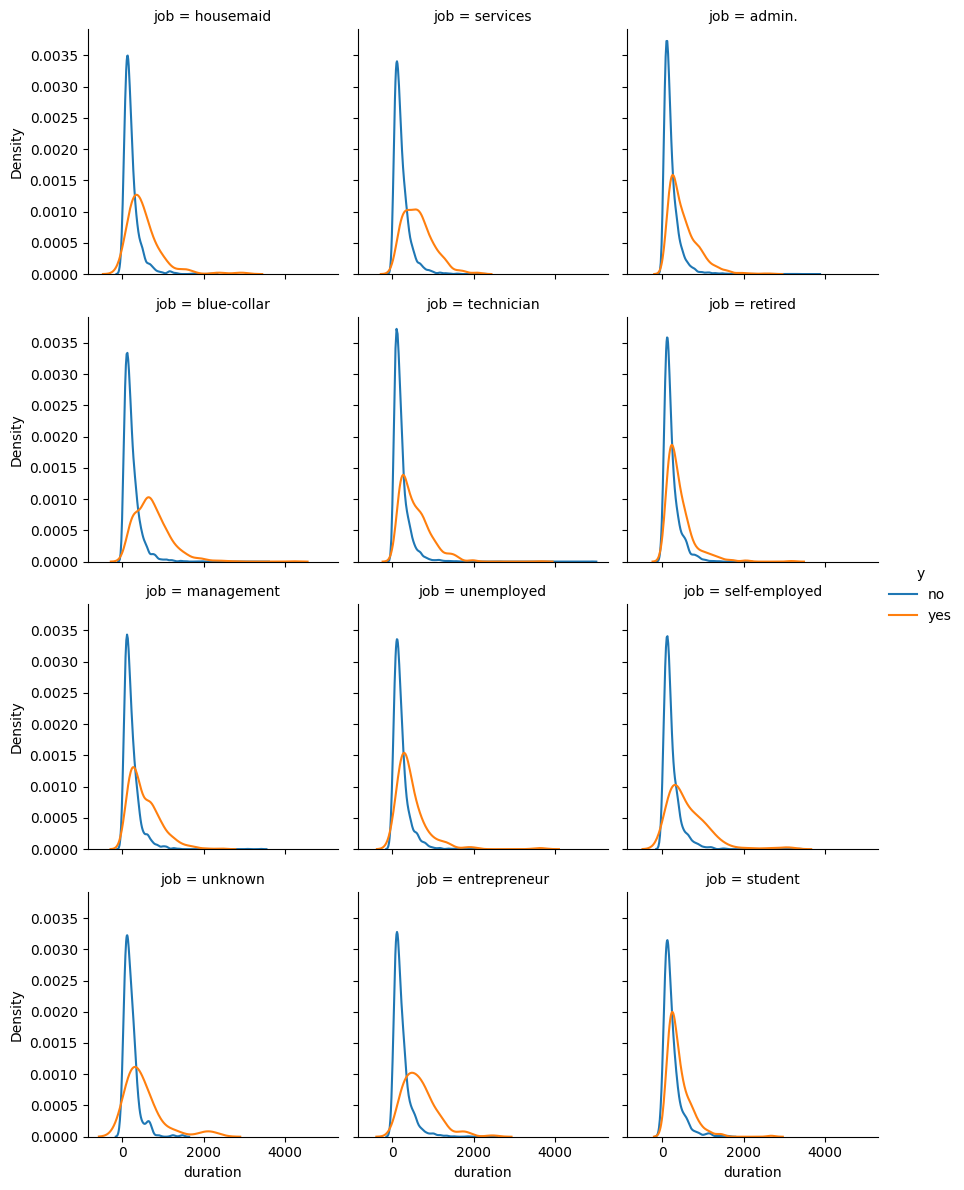

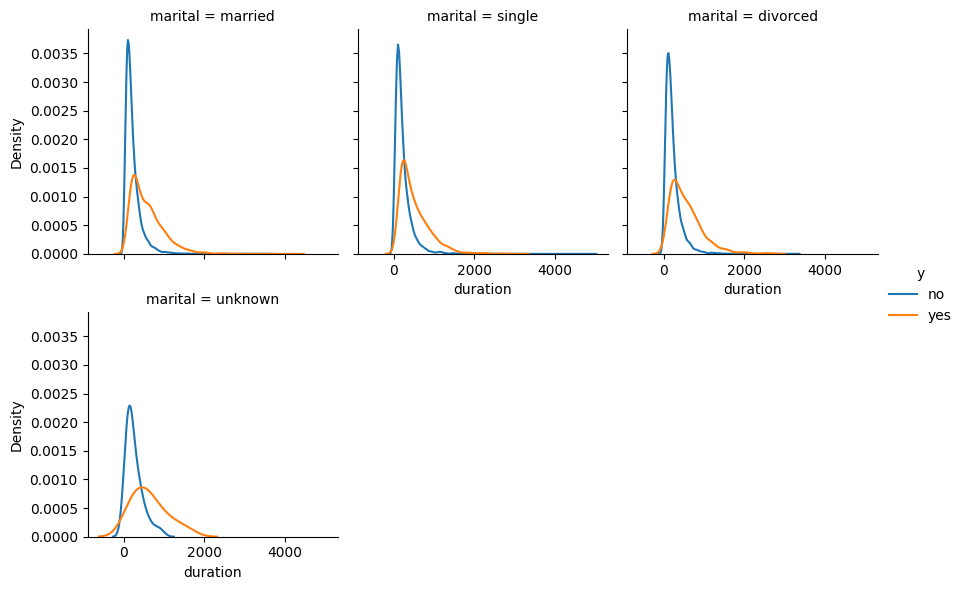

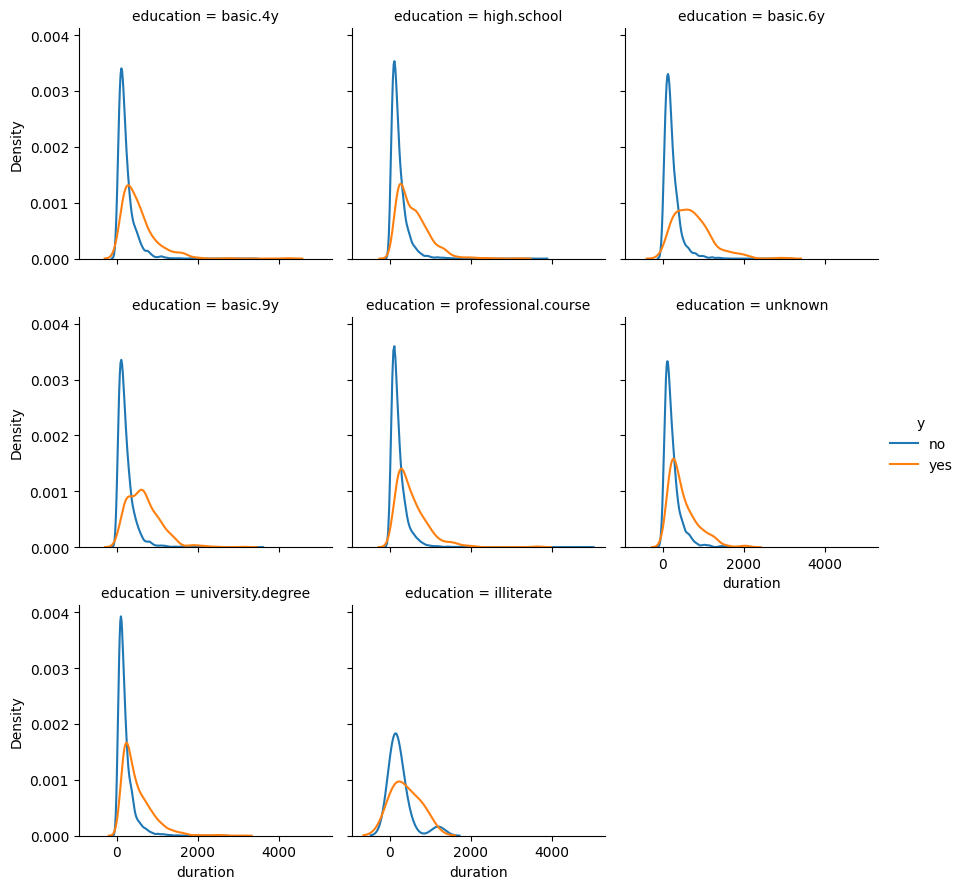

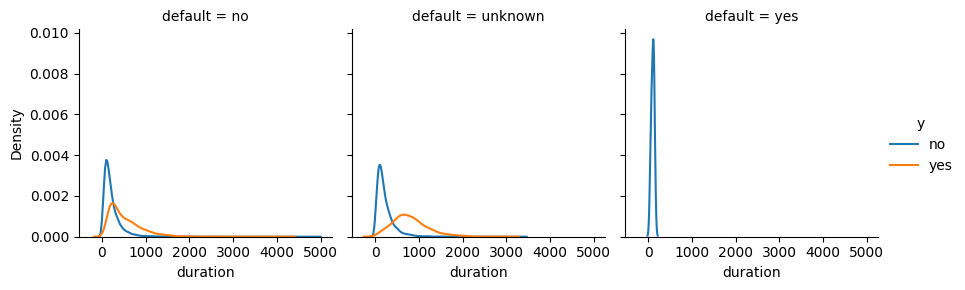

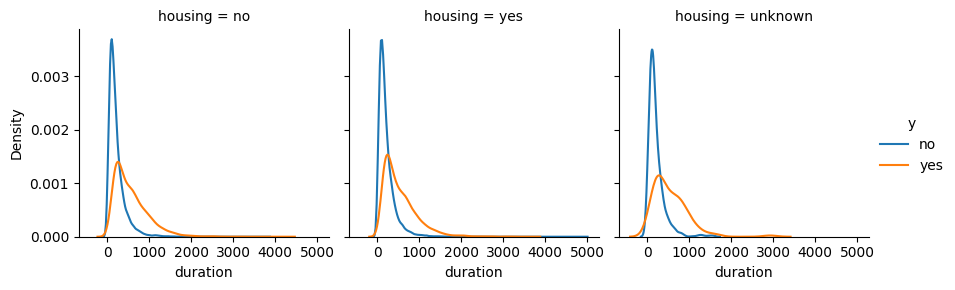

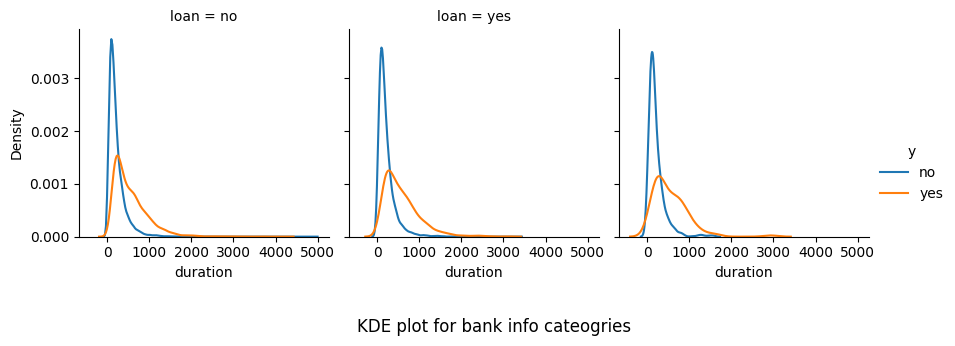

In [8]:
"""
Looping through bank info categorical
features to plot their respective KDEplot chart
against durating in FacetGrid.

"""
for cat in ['job', 'marital', 'education', 'default', 'housing', 'loan']:
  plot_facet_kde(cat)
plt.title('KDE plot for bank info cateogries',y=-0.5, x=-0.5 )

We used KDE plot to see the distribution of various bank category features against duration grouped by target 'y' variable.

Text(0.5, -0.5, 'KDE plot for last contact cateogries')

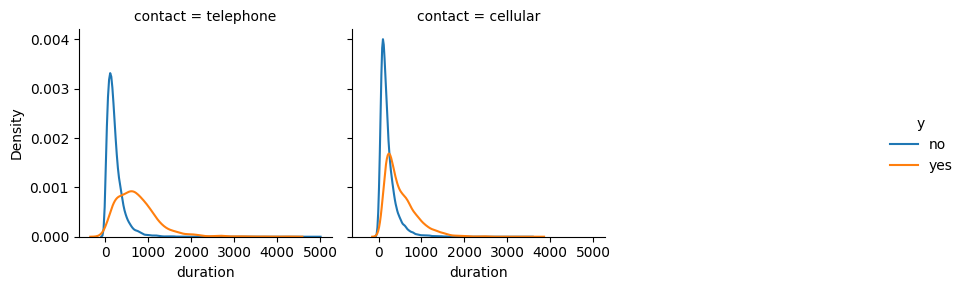

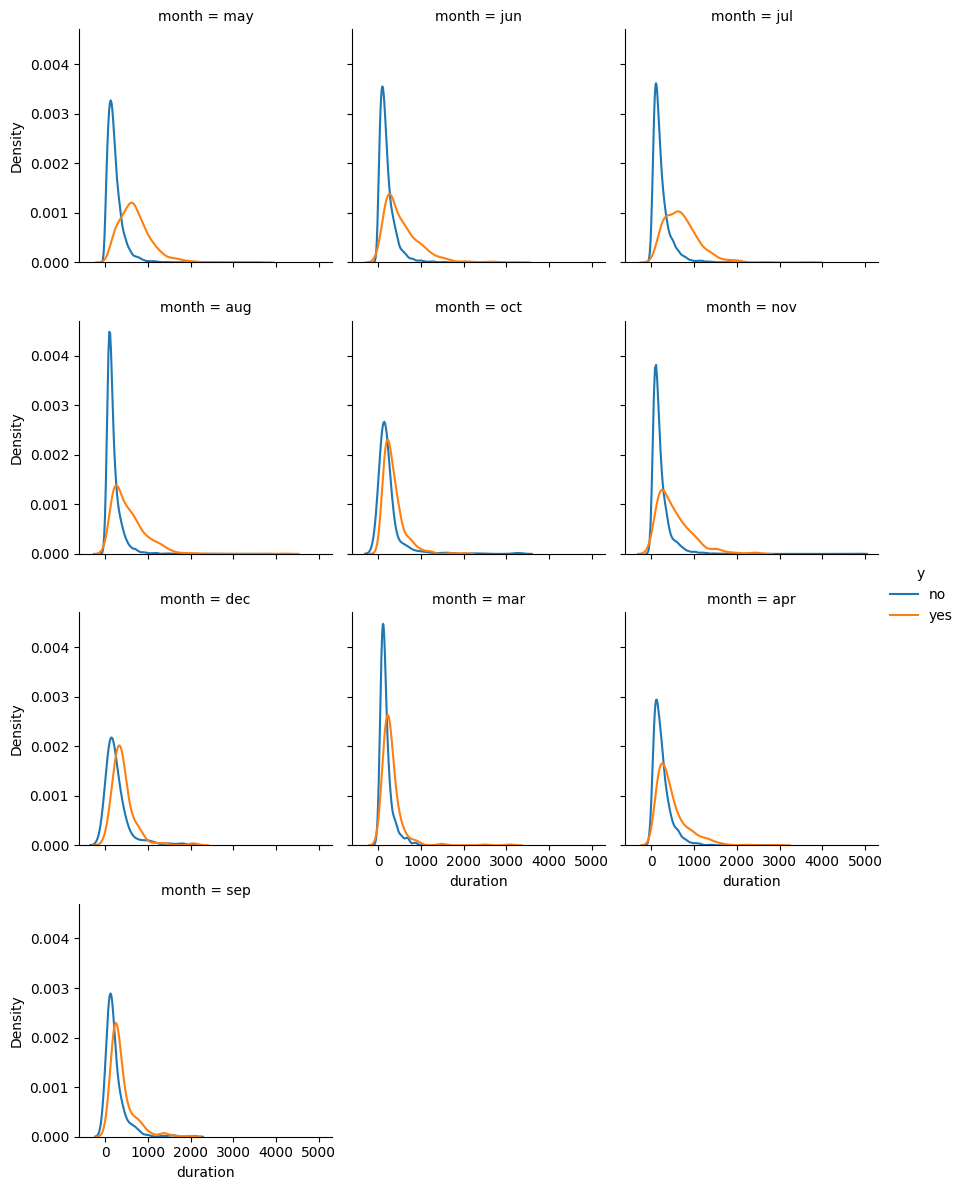

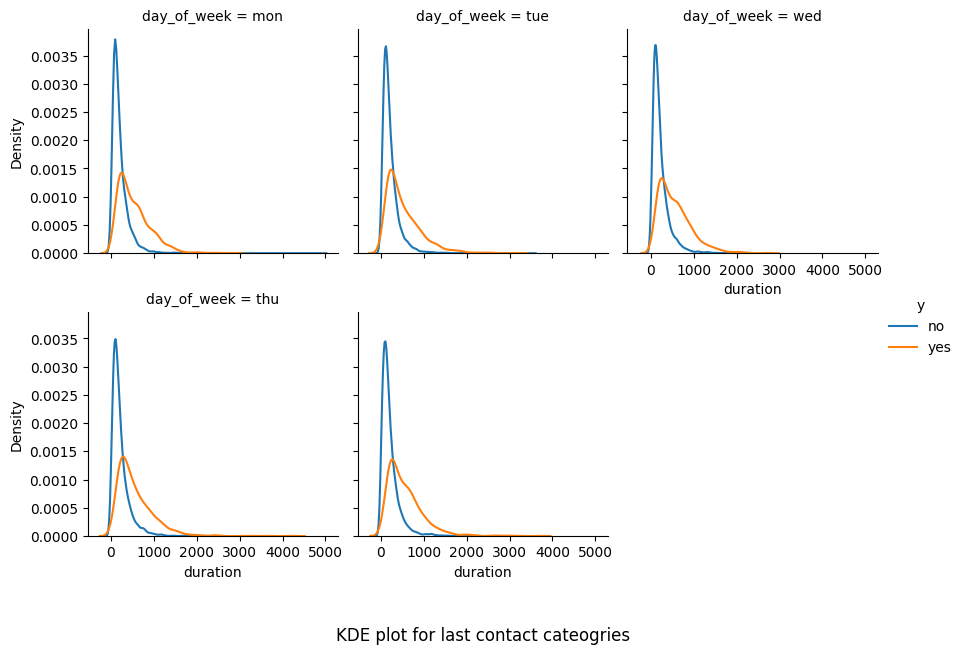

In [9]:
"""
Looping through last contact categorical
features to plot their respective KDEPlot chart
against durating in FacetGrid.

"""
for cat in ['contact', 'month', 'day_of_week']:
  plot_facet_kde(cat)
plt.title('KDE plot for last contact cateogries',y=-0.5 )

KDE plots for last contact categories also revealed similar trend like bank categories where we see similar distribution for subscription to term deposit. One interesting observation to note is monthly data, distribution is almost equally split between both classes in the month of september, october and december.

Text(0.5, -0.5, 'KDE plot poutcome category')

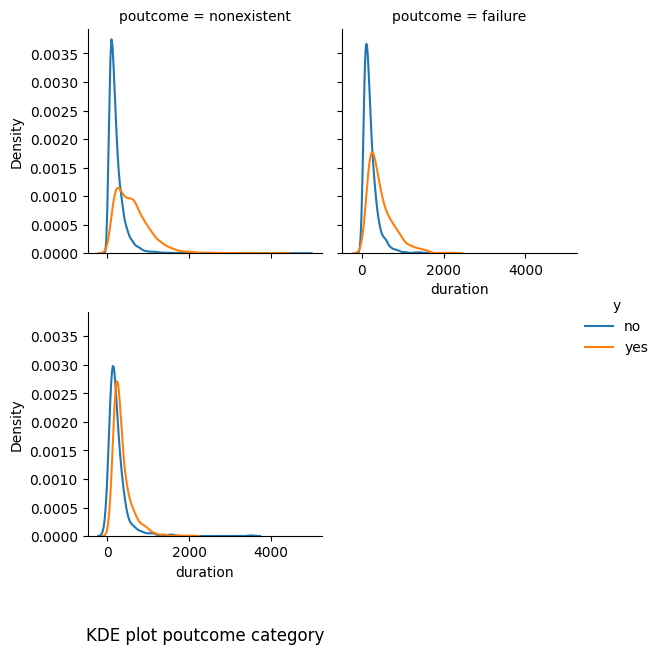

In [10]:
plot_facet_kde('poutcome', col_wrap=2)
plt.title('KDE plot poutcome category',y=-0.5 )

KDE for poutcome category. Success case seems to be having an equal distribution 

In [11]:
def plot_facet_scatter(col):
  """
     Method for FacetGrid rendering for scatter plots
     params(col): col name
     
     returns: FacetGrid plot

  """
  grid = sns.FacetGrid(data=bank, hue='y')
  grid.map(sns.scatterplot, col, "duration")
  grid.add_legend()
  plt.savefig(f"images/{col}_scatter.png")

Text(0.5, -0.5, 'Scatter plot for numeric cateogries against duration')

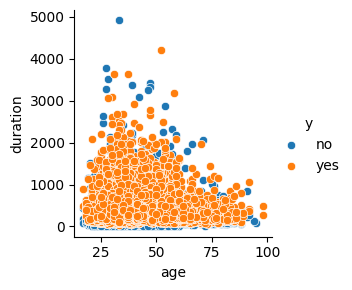

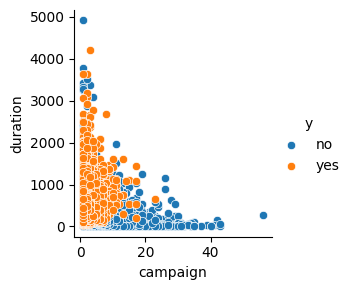

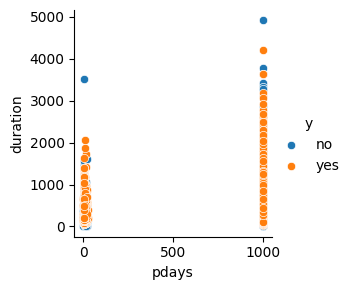

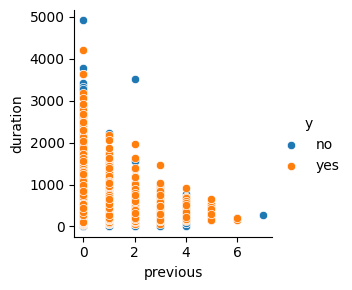

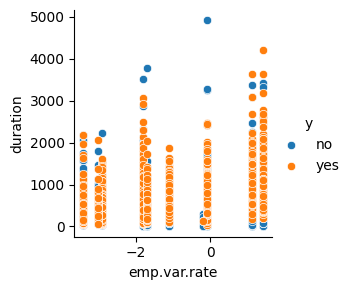

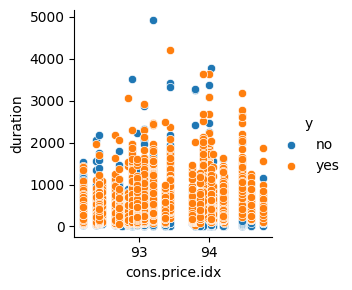

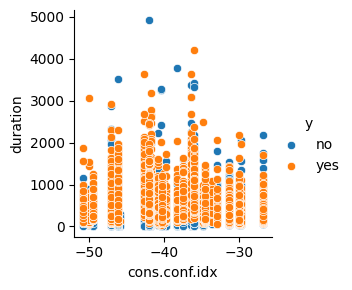

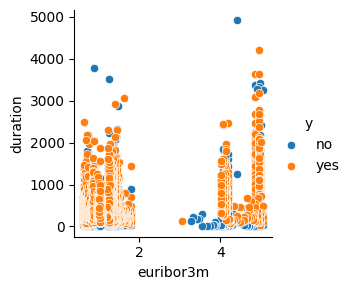

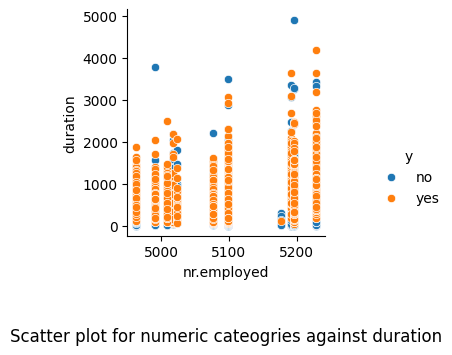

In [12]:
"""
Looping through numeric features
to plot their respective scatterplot chart
against durating in FacetGrid.

"""

for cat in ['age', 
            'campaign', 
            'pdays', 
            'previous', 
            'emp.var.rate',
            'cons.price.idx',
            'cons.conf.idx',
            'euribor3m',
            'nr.employed']:
  plot_facet_scatter(cat)
plt.title('Scatter plot for numeric cateogries against duration',y=-0.5 )

Generated scatter plots for numeric features against durtation. The correlation seems to be balanced but one thing to observe, the plots seem to have 'Yes' classes more than 'no'.

These are the outcomes of data understanding:

 
* Null check revealed data has no null.
* We do need to convert the target variable to numeric (0 or 1) though. 
* The data contains lot of categorical variables which we can convert using a preprocessor (e.g, OneHotEncoding). 

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [13]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

## Business objective

After examining the data, we can conclude that the goal is to increase efficiency of directed campaigns for long-term deposit subscriptions by reducing the number of contacts to do.

With respect to that, we can see in the dataset that our target feature data is 'y' (which indicates that whether the client subscribed a term deposit or not) 

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [14]:
# Converting y to numeric
bank.y.replace({'no': 0, 'yes': 1}, inplace=True)
bank.y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41188, dtype: int64

In [15]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan']

X = bank[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
y = bank['y']

In [16]:
preprocessor = make_column_transformer((OneHotEncoder(sparse_output=False, 
                                                      handle_unknown='ignore',
                                                      drop='if_binary'), categorical_columns),
                                       remainder='passthrough',
                                       verbose_feature_names_out='False')

Initialized the preprocessor which is a OneHotEncoder cateogry tranformer. We will use this to transform all categorical features. For remained features, we are using 'passthrough' so that we can scale them later on.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state =42)

Performed the train/test split with 30% test data and random state of 42 for shuffling.

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [18]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)

In [19]:
dummy_pipe = Pipeline([('preprocess', preprocessor),
                       ('scale', StandardScaler()),
                       ('dummy', dummy_clf)])
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan'])],
                                   verbose_feature_names_out='False')),
                ('scale', StandardScaler()),
                ('dummy',
                 DummyClassifier(random_state=42, strategy='uniform'))])

In [20]:
dummy_train_score = accuracy_score(y_train, dummy_pipe.predict(X_train))
dummy_test_score = accuracy_score(y_test, dummy_pipe.predict(X_test))

print(f"Train accuracy is {dummy_train_score}")
print(f"Test accuracy is {dummy_test_score}")


Train accuracy is 0.5025840241406819
Test accuracy is 0.5020636076717649


In [21]:
def roc_curve_data(pipe, X_test, y_test, svm = False):
  """
  Utility method for generating roc curve

  params(pipe): The target pipeline
  params(X_test): X test data
  params(y_test): y test data

  returns: Tuple containing y pred proba, fpr, tpr and auc
  """
  if(svm):
    y_pred_proba = pipe.decision_function(X_test)
  else:    
    y_pred_proba = pipe.predict_proba(X_test)[::,1]
  fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
  auc = roc_auc_score(y_test, y_pred_proba)
  return (y_pred_proba, fpr, tpr, auc)

In [22]:
dummy_y_pred_proba, dummy_fpr, dummy_tpr, dummy_auc = roc_curve_data(dummy_pipe, X_test, y_test)

We used [DummyClassifer](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) to establish our baseline model. Using the uniform strategy, we could see the model performed at a score of 0.5. This becomes our baseline.  

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [23]:
"""

We are using Pipeline to preprocess, scale nd the apply modeling for
our data. We are also calculating the fit time for model for future use.

"""
basic_lr = LogisticRegression()
basic_lr_pipe = Pipeline([('preprocess', preprocessor),
                          ('scale', StandardScaler()),
                          ('lr', basic_lr)])
time_start = time()
basic_lr_pipe.fit(X_train, y_train)
lr_fit_time = time() - time_start

In [24]:
lr_train_score = accuracy_score(y_train, basic_lr_pipe.predict(X_train))
lr_test_score = accuracy_score(y_test, basic_lr_pipe.predict(X_test))

In [25]:
def print_accuracy(train_score, test_score):
  """
    Method to print accuracy scores

    params(train_score): Training accuracy score
    params(test_score): Test accuracy score

    returns: prints formatted score
    
  """
  print(f"Train accuracy is {train_score}")
  print(f"Test accuracy is {test_score}")

In [26]:
lr_y_pred_proba, lr_fpr, lr_tpr, lr_auc = roc_curve_data(basic_lr_pipe, X_test, y_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [27]:
print_accuracy(lr_train_score, lr_test_score)

Train accuracy is 0.8872394297804447
Test accuracy is 0.8875940762320952


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [28]:
# Dictonary for the result dataframe
comparison = {'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
              'Train Time': [0,0,0,0],
              'Train Accuracy': [0,0,0,0],
              'Test Accuracy': [0,0,0,0]}

KNN

In [29]:
"""
Same like LR, we are using Pipeline.

"""
knn_pipe  = Pipeline([('preprocess', preprocessor),
                          ('scale', StandardScaler()),
                          ('knn', KNeighborsClassifier())])
time_start = time()
knn_pipe.fit(X_train, y_train)
knn_fit_time = time() - time_start

In [30]:
knn_training_score = accuracy_score(y_train, knn_pipe.predict(X_train))
knn_test_score = accuracy_score(y_test, knn_pipe.predict(X_test))

print_accuracy(knn_training_score, knn_test_score)

Train accuracy is 0.8890777288335472
Test accuracy is 0.8762644654851501


In [31]:
knn_y_pred_proba, knn_fpr, knn_tpr, knn_auc = roc_curve_data(knn_pipe, X_test, y_test)

Decision Tree

In [32]:
dt_pipe  = Pipeline([('preprocess', preprocessor),
                          ('scale', StandardScaler()),
                          ('dt', DecisionTreeClassifier())])
time_start = time()
dt_pipe.fit(X_train, y_train)
dt_fit_time = time() - time_start

In [33]:
dt_training_score = accuracy_score(y_train, dt_pipe.predict(X_train))
dt_test_score = accuracy_score(y_test, dt_pipe.predict(X_test))

print_accuracy(dt_training_score, dt_test_score)

Train accuracy is 0.9179702403662724
Test accuracy is 0.8629926357530144


In [34]:
dt_y_pred_proba, dt_fpr, dt_tpr, dt_auc = roc_curve_data(dt_pipe, X_test, y_test)

Support Vector Machine

In [35]:
svm_pipe = Pipeline([('preprocessor', preprocessor),
                     ('scale', StandardScaler()),
                     ('svm', SVC())])
time_start = time()
svm_pipe.fit(X_train, y_train)
svm_fit_time = time() - time_start

In [36]:
svm_training_score = accuracy_score(y_train, svm_pipe.predict(X_train))
svm_test_score = accuracy_score(y_test, svm_pipe.predict(X_test))

print_accuracy(svm_training_score, svm_test_score)

Train accuracy is 0.8875169088827998
Test accuracy is 0.8877559278141944


In [37]:
svm_y_pred_proba, svm_fpr, svm_tpr, svm_auc = roc_curve_data(svm_pipe, X_test, y_test, svm=True)

In [38]:
# Populating the rest of the dict with time and score data
comparison['Train Time'] = [lr_fit_time, knn_fit_time, dt_fit_time, svm_fit_time]
comparison['Train Accuracy'] = [lr_train_score, knn_training_score, dt_training_score, svm_training_score]
comparison['Test Accuracy'] = [lr_test_score, knn_test_score, dt_test_score, svm_test_score]

comparison_df = pd.DataFrame(comparison)

In [39]:
comparison_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,0.199302,0.887239,0.887594
1,KNN,0.130151,0.889078,0.876264
2,Decision Tree,0.202320,0.917970,0.862993
3,SVM,39.394233,0.887517,0.887756


Faster running algorithm turned out to be KNN where SVM is the slowest of the batch. But performance wise, both SVM and Logistic Regression seem to have outperformed all the other models. KNN and Decision Tree seems to be reflecting an overfitting issue as test scores are worse than training score.

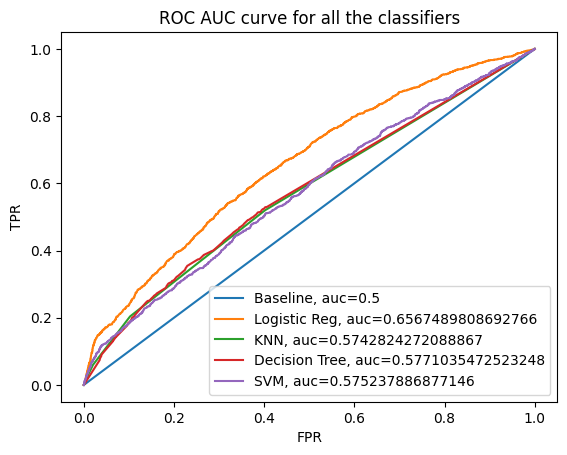

<Figure size 640x480 with 0 Axes>

In [40]:
plt.plot(dummy_fpr,dummy_tpr,label="Baseline, auc="+str(dummy_auc))
plt.plot(lr_fpr,lr_tpr,label="Logistic Reg, auc="+str(lr_auc))
plt.plot(knn_fpr,knn_tpr,label="KNN, auc="+str(knn_auc))
plt.plot(dt_fpr,dt_tpr,label="Decision Tree, auc="+str(dt_auc))
plt.plot(svm_fpr,svm_tpr,label="SVM, auc="+str(svm_auc))
plt.legend(loc=4)
plt.title("ROC AUC curve for all the classifiers")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
plt.savefig("images/base_roc_auc_curve.png")

The above ROC curve show cases the AUC scores for various models and how they performed. The results are not very far off from Baseline. We should try to improve the model so that we can try to reach as close as possible to best score of auc=1.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

More feature engineering and exploration (There is no gender feature so the ask is not valid).

<ipython-input-41-972e08905da2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data=bank.corr(), annot=True, fmt=".1f")


Text(0.5, 1.0, 'Numeric features correlation matrix heatmap')

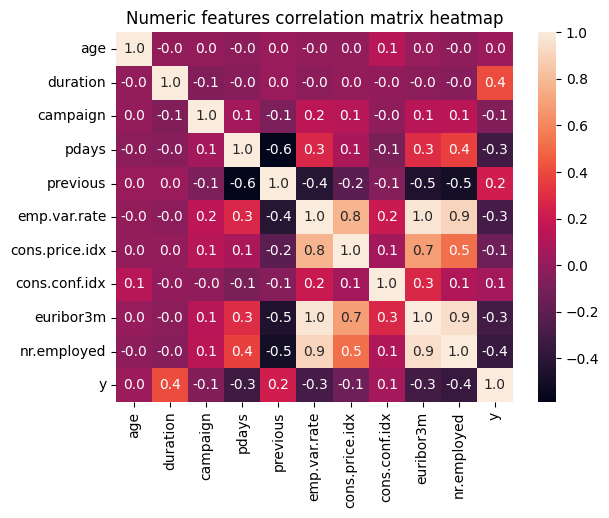

In [41]:
sns.heatmap(data=bank.corr(), annot=True, fmt=".1f")
plt.title('Numeric features correlation matrix heatmap')

We generated a heatmap for correlation between numeric features in the dataset. In the data description, it was mentioned duration is an important feature which has a strong impact on the target variable. Keeping that idea in mind, we have decided a threshold of 0.4 (positive or negative) and consider those features which are equal or greater than our threshold for feature selection.

We are doing this because selecting all features resulting in the fit to be run for a very long run (almost indefinite for SVM).

In [146]:
"""
Now X will contain both categorical as well as numeric features.
Dropping all numeric features with correlation score < 0.3 and the target.

"""
X = bank.drop(columns=['y', 
                       'age', 
                       'campaign',
                       'previous',
                       'cons.price.idx',
                       'cons.conf.idx',
                       'euribor3m',
                       'emp.var.rate',
                       'pdays'], axis=1)
y = bank['y']

In [147]:
# Time to update categorical features too
categorical_columns = ['job', 
                       'marital', 
                       'education', 
                       'default', 
                       'housing', 
                       'loan',
                       'contact', 
                       'month', 
                       'day_of_week',
                       'poutcome']

In [148]:
preprocessor = make_column_transformer((OneHotEncoder(sparse_output=False, 
                                                      handle_unknown='ignore',
                                                      drop='if_binary'), categorical_columns),
                                       remainder='passthrough',
                                       verbose_feature_names_out='False')

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state =42)

Bulding a new Baseline model performance with new data.

In [150]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=42)

In [151]:
dummy_pipe = Pipeline([('preprocess', preprocessor),
                       ('scale', StandardScaler()),
                       ('dummy', dummy_clf)])
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])],
                                   verbose_feature_names_out='False')),
                ('scale', StandardScaler()),
                ('dummy',
                 DummyClassifier(random_state=42, strategy='uniform'))])

In [152]:
dummy_train_score = accuracy_score(y_train, dummy_pipe.predict(X_train))
dummy_test_score = accuracy_score(y_test, dummy_pipe.predict(X_test))

print_accuracy(dummy_train_score, dummy_test_score)

Train accuracy is 0.5025840241406819
Test accuracy is 0.5020636076717649


In [153]:
new_dummy_y_pred_proba, new_dummy_fpr, new_dummy_tpr, new_dummy_auc = roc_curve_data(dummy_pipe, X_test, y_test)

Dummy Classfier again resulted in similar accuracy score like before which was kind of expected given the strategy.

Hyperparameter tuning and Grid search.

In [154]:
"""
We are initalizing a new comparison dict
which we will be using to visualize the updated
results

"""
new_comparison = {'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'SVM'],
              'Train Time': [0,0,0,0],
              'Train Accuracy': [0,0,0,0],
              'Test Accuracy': [0,0,0,0]}

In [155]:
def calculate_run_time(cv):
  """
  Utility method to calculate the run time based on CV mean_fit_time
  and mean_score_time

  params(cv): cross valid search
  returns: run time(numeric in seconds) 

  """
  mean_fit_time= cv.cv_results_['mean_fit_time']
  mean_score_time= cv.cv_results_['mean_score_time']
  n_splits  = cv.n_splits_ #number of splits of training data
  n_iter = pd.DataFrame(cv.cv_results_).shape[0] #Iterations per split
  return np.mean(mean_fit_time + mean_score_time) * n_splits * n_iter

Now, like before, we will perform classification with our chosen models. This time though we will using GridSearch and Hyperparameter tuning to choose the best model. We will perform the following steps for each model:
* Build Grid for GridSearchCV/RandomSearchCV and fit
* Check best params revealed by GridSearchCV/RandomSearchCV.
* Check best accuracy score revealed by GridSearchCV/RandomSearchCV.
* Generate a Confusion Matrix to check TN, TP, FN, FP.
* Printout the following score:
    - Accuracy Score (both train and test): To check the accuracy and to see if we are overfitting.
    - Balanced accuracy score: To check how the model performed for imbalanced data.    
    - Precision score: To check the precision
    - Recall score: To check the recall
* Calculate ROC AUC data.
* Calculate runtime.

Please note, we are choosing precision over recall for our data as we are trying to predict will a client subscribe for term deposit. We dont mind a bit of false positive in this case.



Logistic Regression with Grid Search. We will be attempting a grid search with max_iter 100 and 1000 (10 causing failed convergence). The two solver we would be using are liblinear and lbfgs.

In [156]:
def generate_confusion_matrix(conf_mat, model):
  """
  Utility method for generating confusion matrix.

  params(conf_mat): Confusion Matrix based on which plot will be generated
  return: Confusion Matrix plot

  """
  ax = plt.subplot()
  ConfusionMatrixDisplay(conf_mat).plot(ax=ax)
  ax.set_title(f"Confusion Matrix for {model}")
  ax.xaxis.set_ticklabels(['no', 'yes'])
  ax.yaxis.set_ticklabels(['no', 'yes'])
  

In [157]:
lr_pipe = Pipeline([('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('lr', LogisticRegression())])
lr_params = {'lr__solver': ['liblinear', 'lbfgs'],
             'lr__max_iter' : [100, 1000]}
lr_grid = GridSearchCV(estimator = lr_pipe, param_grid=lr_params, cv=5)
lr_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])],
                                                          verbose_feature_names_out='False')),
                                       ('scale', StandardScaler()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__max_iter': [100, 1000],
                         'lr__solver': ['liblinear', 'lbfgs']})

In [158]:
lr_grid.best_params_

{'lr__max_iter': 100, 'lr__solver': 'liblinear'}

In [159]:
lr_grid.best_score_

0.909056341651319

In [160]:
cm = confusion_matrix(y_test, lr_grid.predict(X_test))
cm

array([[10701,   267],
       [  837,   552]])

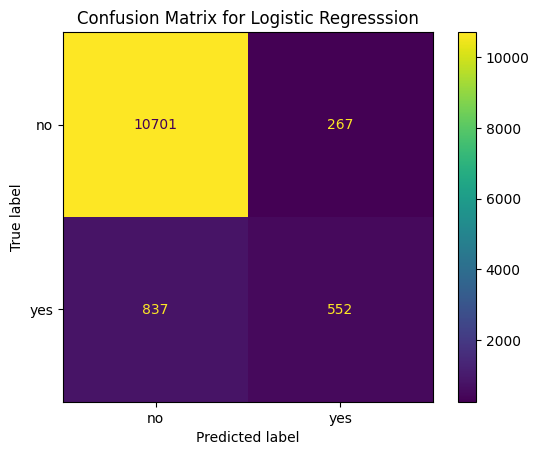

In [161]:
generate_confusion_matrix(cm, "Logistic Regresssion")

In [162]:
print(f"train accuracy score: {accuracy_score(y_train, lr_grid.predict(X_train))}")
print(f"test accuracy score: {accuracy_score(y_test, lr_grid.predict(X_test))}")
print(f"balanced accuracy score: {balanced_accuracy_score(y_test, lr_grid.predict(X_test))}")
print("\n\n\n")
print(f"precision score: {precision_score(y_test, lr_grid.predict(X_test))}")
print(f"recall score: {recall_score(y_test, lr_grid.predict(X_test))}")

train accuracy score: 0.9099580312857688
test accuracy score: 0.9106579266812334
balanced accuracy score: 0.6865323312428222




precision score: 0.673992673992674
recall score: 0.39740820734341253


In [163]:
best_lr_train_score = accuracy_score(y_train, lr_grid.predict(X_train))
best_lr_test_score = accuracy_score(y_test, lr_grid.predict(X_test))

In [164]:
best_lr_y_pred_proba, best_lr_fpr, best_lr_tpr, best_lr_auc = roc_curve_data(lr_grid, X_test, y_test)

In [165]:
best_lr_runtime = calculate_run_time(lr_grid) 
print(f"{best_lr_runtime} seconds")

8.709563970565796 seconds


KNN with grid search. We decided to use 1 to 20 as n_neighbors hyperparameters.

In [166]:
knn_pipe = Pipeline([('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn_grid = GridSearchCV(estimator = knn_pipe, param_grid=knn_params, cv=5)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])],
                                                          verbose_feature_names_out='False')),
                                       ('scale', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20]})

In [167]:
knn_grid.best_params_

{'knn__n_neighbors': 11}

In [168]:
knn_grid.best_score_

0.8969512868828415

In [169]:
cm = confusion_matrix(y_test, lr_grid.predict(X_test))
cm

array([[10701,   267],
       [  837,   552]])

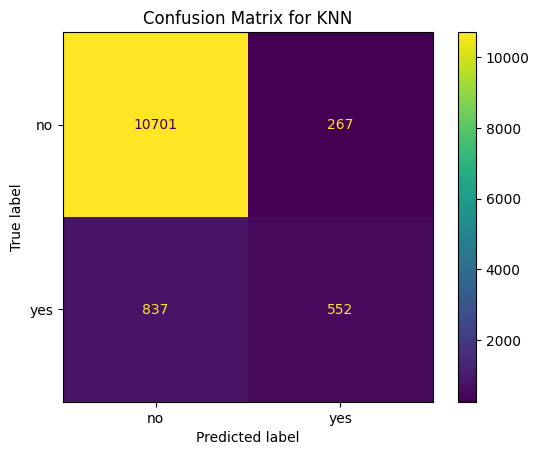

In [170]:
generate_confusion_matrix(cm, "KNN")

In [171]:
print(f"train accuracy score: {accuracy_score(y_train, knn_grid.predict(X_train))}")
print(f"test accuracy score: {accuracy_score(y_test, knn_grid.predict(X_test))}")
print(f"balanced accuracy score: {balanced_accuracy_score(y_test, knn_grid.predict(X_test))}")
print("\n\n\n")
print(f"precision score: {precision_score(y_test, knn_grid.predict(X_test))}")
print(f"recall score: {recall_score(y_test, knn_grid.predict(X_test))}")

train accuracy score: 0.9061080087405917
test accuracy score: 0.8992473901432386
balanced accuracy score: 0.6109400525857275




precision score: 0.6384615384615384
recall score: 0.23902087832973362


In [109]:
best_knn_train_score = accuracy_score(y_train, knn_grid.predict(X_train))
best_knn_test_score = accuracy_score(y_test, knn_grid.predict(X_test))

In [172]:
best_knn_runtime = calculate_run_time(knn_grid)
print(f"{best_knn_runtime} seconds")

139.41592454910278 seconds


In [173]:
best_knn_y_pred_proba, best_knn_fpr, best_knn_tpr, best_knn_auc = roc_curve_data(knn_grid, X_test, y_test)

Decision Trees Grid Search. We decided to use 1 to 6 for max_depth; 0.05, 0.1, 0.5, 2 for min_samples_split; 0.05, 0.1, 0.5, 2, 5 for min_samples_leaf and crierion as gini, entropy and log_loss for hyperparameter tuning.

In [174]:
dt_pipe = Pipeline([('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('dt', DecisionTreeClassifier())])
dt_params = {'dt__max_depth': [1,2,3,4,5,6],
             'dt__min_samples_split':  [0.05, 0.1, 0.5, 2],
             'dt__criterion': ['gini', 'entropy', 'log_loss'],
             'dt__min_samples_leaf': [0.05, 0.1, 0.5, 2, 5]}
dt_grid = RandomizedSearchCV(estimator = dt_pipe, param_distributions=dt_params, cv=5)
dt_grid.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(drop='if_binary',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['job',
                                                                                'marital',
                                                                                'education',
                                                                                'default',
                                                                                'housing',
                                                                                'loan',
                                                                                'contact',
                                                                                'month',
                                                                                'day_of_week',
                                                                                'poutcome'])],
                                                                verbose_feature_names_out='False')),
                                             ('scale', StandardScaler()),
                                             ('dt', DecisionTreeClassifier())]),
                   param_distributions={'dt__criterion': ['gini', 'entropy',
                                                          'log_loss'],
                                        'dt__max_depth': [1, 2, 3, 4, 5, 6],
                                        'dt__min_samples_leaf': [0.05, 0.1, 0.5,
                                                                 2, 5],
                                        'dt__min_samples_split': [0.05, 0.1,
                                                                  0.5, 2]})

In [175]:
dt_grid.best_params_

{'dt__min_samples_split': 2,
 'dt__min_samples_leaf': 2,
 'dt__max_depth': 5,
 'dt__criterion': 'entropy'}

In [176]:
dt_grid.best_score_

0.9119699371975456

In [177]:
cm = confusion_matrix(y_test, lr_grid.predict(X_test))
cm

array([[10701,   267],
       [  837,   552]])

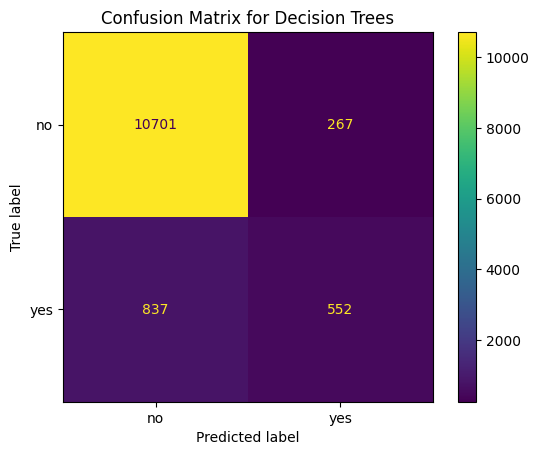

In [178]:
generate_confusion_matrix(cm, "Decision Trees")

In [179]:
print(f"train accuracy score: {accuracy_score(y_train, dt_grid.predict(X_train))}")
print(f"test accuracy score: {accuracy_score(y_test, dt_grid.predict(X_test))}")
print(f"balanced accuracy score: {balanced_accuracy_score(y_test, dt_grid.predict(X_test))}")
print("\n\n\n")
print(f"precision score: {precision_score(y_test, dt_grid.predict(X_test))}")
print(f"recall score: {recall_score(y_test, dt_grid.predict(X_test))}")

train accuracy score: 0.9142242724844785
test accuracy score: 0.9121955167111758
balanced accuracy score: 0.7018601531571128




precision score: 0.6704035874439462
recall score: 0.43052555795536357


In [180]:
best_dt_train_score = accuracy_score(y_train, dt_grid.predict(X_train))
best_dt_test_score = accuracy_score(y_test, dt_grid.predict(X_test))

In [181]:
best_dt_runtime = calculate_run_time(dt_grid)
print(f"{best_dt_runtime} seconds")

9.556552171707155 seconds


In [182]:
best_dt_y_pred_proba, best_dt_fpr, best_dt_tpr, best_dt_auc = roc_curve_data(dt_grid, X_test, y_test)

Support Vector Machine. We are initializing the constructor with kernel='rbf' and cache size of 2000mb to speed up the process. We can't perform too much of hyperparameters tuning due to overall performance of SVM. We decided to experiment with C for values 0.1, 1 and 10 and see how they perform.

In [183]:
svm_pipe = Pipeline([('preprocess', preprocessor),
                    ('scale', StandardScaler()),
                    ('svc', SVC(cache_size=2000))])
svm_params =  {
               'svc__kernel': ['rbf'],
               'svc__C': [0.1, 1, 10]
               }
svm_grid = GridSearchCV(estimator = svm_pipe, 
                              scoring='accuracy', 
                              param_grid=svm_params,
                              verbose=42,
                              n_jobs=-1)
svm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['job',
                                                                          'marital',
                                                                          'education',
                                                                          'default',
                                                                          'housing',
                                                                          'loan',
                                                                          'contact',
                                                                          'month',
                                                                          'day_of_week',
                                                                          'poutcome'])],
                                                          verbose_feature_names_out='False')),
                                       ('scale', StandardScaler()),
                                       ('svc', SVC(cache_size=2000))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10], 'svc__kernel': ['rbf']},
             scoring='accuracy', verbose=42)

In [184]:
svm_grid.best_params_

{'svc__C': 1, 'svc__kernel': 'rbf'}

In [185]:
svm_grid.best_score_

0.9062468103923065

In [186]:
cm = confusion_matrix(y_test, lr_grid.predict(X_test))
cm

array([[10701,   267],
       [  837,   552]])

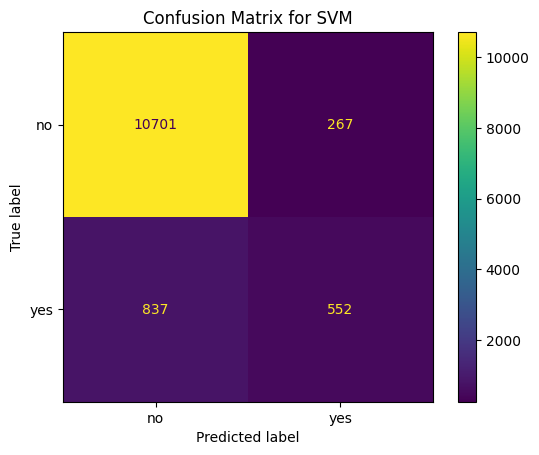

In [187]:
generate_confusion_matrix(cm, "SVM")

In [188]:
print(f"train accuracy score: {accuracy_score(y_train, svm_grid.predict(X_train))}")
print(f"test accuracy score: {accuracy_score(y_test, svm_grid.predict(X_test))}")
print(f"balanced accuracy score: {balanced_accuracy_score(y_test, svm_grid.predict(X_test))}")
print("\n\n\n")
print(f"precision score: {precision_score(y_test, svm_grid.predict(X_test))}")
print(f"recall score: {recall_score(y_test, svm_grid.predict(X_test))}")

train accuracy score: 0.9261558738857479
test accuracy score: 0.9091203366512908
balanced accuracy score: 0.6784353422404544




precision score: 0.6679292929292929
recall score: 0.380849532037437


In [189]:
best_svm_train_score = accuracy_score(y_train, svm_grid.predict(X_train))
best_svm_test_score = accuracy_score(y_test, svm_grid.predict(X_test))

In [190]:
best_svm_runtime = calculate_run_time(svm_grid)
print(f"{best_svm_runtime} seconds")

434.606056690216 seconds


In [191]:
best_svm_y_pred_proba, best_svm_fpr, best_svm_tpr, best_svm_auc = roc_curve_data(svm_grid, X_test, y_test, svm=True)

In [192]:
new_comparison['Train Time'] = [best_lr_runtime, best_knn_runtime, best_dt_runtime, best_svm_runtime]
new_comparison['Train Accuracy'] = [best_lr_train_score, best_knn_train_score, best_dt_train_score, best_svm_train_score]
new_comparison['Test Accuracy'] = [best_lr_test_score, best_knn_test_score, best_dt_test_score, best_svm_test_score]

new_comparison_df = pd.DataFrame(new_comparison)

In [193]:
new_comparison_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Logistic Regression,8.709564,0.909958,0.910658
1,KNN,139.415925,0.904963,0.898843
2,Decision Tree,9.556552,0.914224,0.912196
3,SVM,434.606057,0.926156,0.909120


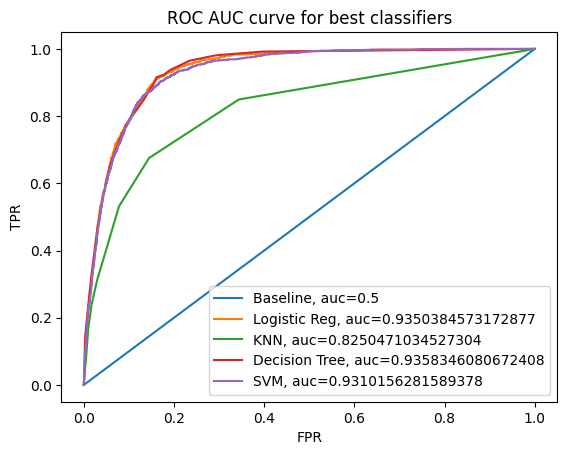

<Figure size 640x480 with 0 Axes>

In [194]:
plt.plot(new_dummy_fpr,new_dummy_tpr,label="Baseline, auc="+str(new_dummy_auc))
plt.plot(best_lr_fpr,best_lr_tpr,label="Logistic Reg, auc="+str(best_lr_auc))
plt.plot(best_knn_fpr,best_knn_tpr,label="KNN, auc="+str(best_knn_auc))
plt.plot(best_dt_fpr,best_dt_tpr,label="Decision Tree, auc="+str(best_dt_auc))
plt.plot(best_svm_fpr,best_svm_tpr,label="SVM, auc="+str(best_svm_auc))
plt.legend(loc=4)
plt.title("ROC AUC curve for best classifiers")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()
plt.savefig("images/best_roc_auc_curve.png")

As we can see in the above ROC curve, the performance has greatly improved after we have increased the number of features using feature exploration and tuned hyperparameters using GridSearchCV and RandmoizedSearchCV( for decision trees).

In [196]:
def print_important_features(model):
  """
  Utility method for printing important features
  using permutation imporatnce. We are using r2, neg_mape and neg_mse

  params(model): The target model
  returns: prints important features for the model.
  
  """
  scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
  r_multi = permutation_importance(model, X_test, y_test, 
                           n_repeats=30, random_state=0, scoring=scoring)
  for metric in r_multi:
    print(f"{metric}")
    r = r_multi[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {X.columns[i]:<8}"
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")


In [197]:
print("Logistic Regression important features")
print_important_features(lr_grid)

Logistic Regression important features
r2
    duration0.341 +/- 0.015
    nr.employed0.189 +/- 0.017
    poutcome0.052 +/- 0.006
neg_mean_absolute_percentage_error
    duration66319091380905.656 +/- 5390588739128.806
    housing 1579315237134.598 +/- 680754149389.264
neg_mean_squared_error
    duration0.034 +/- 0.002
    nr.employed0.019 +/- 0.002
    poutcome0.005 +/- 0.001


In [198]:
print("\nDecision trees important features")
print_important_features(dt_grid)


Decision trees important features
r2
    duration0.420 +/- 0.015
    nr.employed0.369 +/- 0.017
    month   0.075 +/- 0.005
    poutcome0.052 +/- 0.003
neg_mean_absolute_percentage_error
    duration74616570665235.844 +/- 5905958807215.362
    nr.employed70704728308640.953 +/- 4772397180431.402
    month   31343333167748.047 +/- 2244694443523.895
    job     643874673601.020 +/- 154148183439.965
neg_mean_squared_error
    duration0.042 +/- 0.001
    nr.employed0.037 +/- 0.002
    month   0.007 +/- 0.001
    poutcome0.005 +/- 0.000


### Conclusion
Post our analysis we can conclude that out of all the models, Decision Tree seem to have performed the best with respect to  accuracy score of 0.912 and runtime of 9 seconds. Next best is Logistic Regression with score of 0.91 and runtime of 8 seconds. Last is SVM with score of 0.90 and a lengthy runtime of around 430 seconds.

Top 3 important features(r2) revealed for DT estimator are:
1. Duration
2. Number of employees
3. Last contact month of year


### Takeways
* The decision tree must have perfomed well because we had a binary classification problem in hand and DT is known to perform well in these scenarios. 
* SVM is a very unoptimized algorithm (possibly because its comparing hyperplanes and runtime of O(N^2)) and we should reconsider when we are trying to applying for a big dataset.

### Future considerations and next steps
* May be experiment a bit more with SVC's hyperparameters and see if we can improve the speed.
* Experiment with all the features to see if they reveal any significant difference.





##### Questions